In [1]:
import pandas as pd
import json
import ollama
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
X = 2

In [3]:
base_path = 'C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/'
csv_file = 'C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample_labels.csv'

df = pd.read_csv(csv_file)
df['Image_Full_Path'] = base_path + df['Image Index']
df.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image_Full_Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,C:/Users/adity/Downloads/Sample_NIH Chest X-ra...
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,C:/Users/adity/Downloads/Sample_NIH Chest X-ra...


In [4]:
df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)
df = df[~df['Finding Labels'].str.contains('|', regex=False)]
df['Patient Age'] = df['Patient Age'].str.replace(r'\D', '', regex=True).astype(int)

In [5]:
df['Finding Labels'].value_counts()

Infiltration          503
Effusion              203
Atelectasis           192
Nodule                144
Pneumothorax          114
Mass                   99
Consolidation          72
Pleural_Thickening     65
Cardiomegaly           50
Emphysema              42
Edema                  41
Fibrosis               38
Pneumonia              14
Hernia                  5
Name: Finding Labels, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582 entries, 3 to 5603
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  1582 non-null   object 
 1   Finding Labels               1582 non-null   object 
 2   Follow-up #                  1582 non-null   int64  
 3   Patient ID                   1582 non-null   int64  
 4   Patient Age                  1582 non-null   int32  
 5   Patient Gender               1582 non-null   object 
 6   View Position                1582 non-null   object 
 7   OriginalImageWidth           1582 non-null   int64  
 8   OriginalImageHeight          1582 non-null   int64  
 9   OriginalImagePixelSpacing_x  1582 non-null   float64
 10  OriginalImagePixelSpacing_y  1582 non-null   float64
 11  Image_Full_Path              1582 non-null   object 
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 154.5+ KB


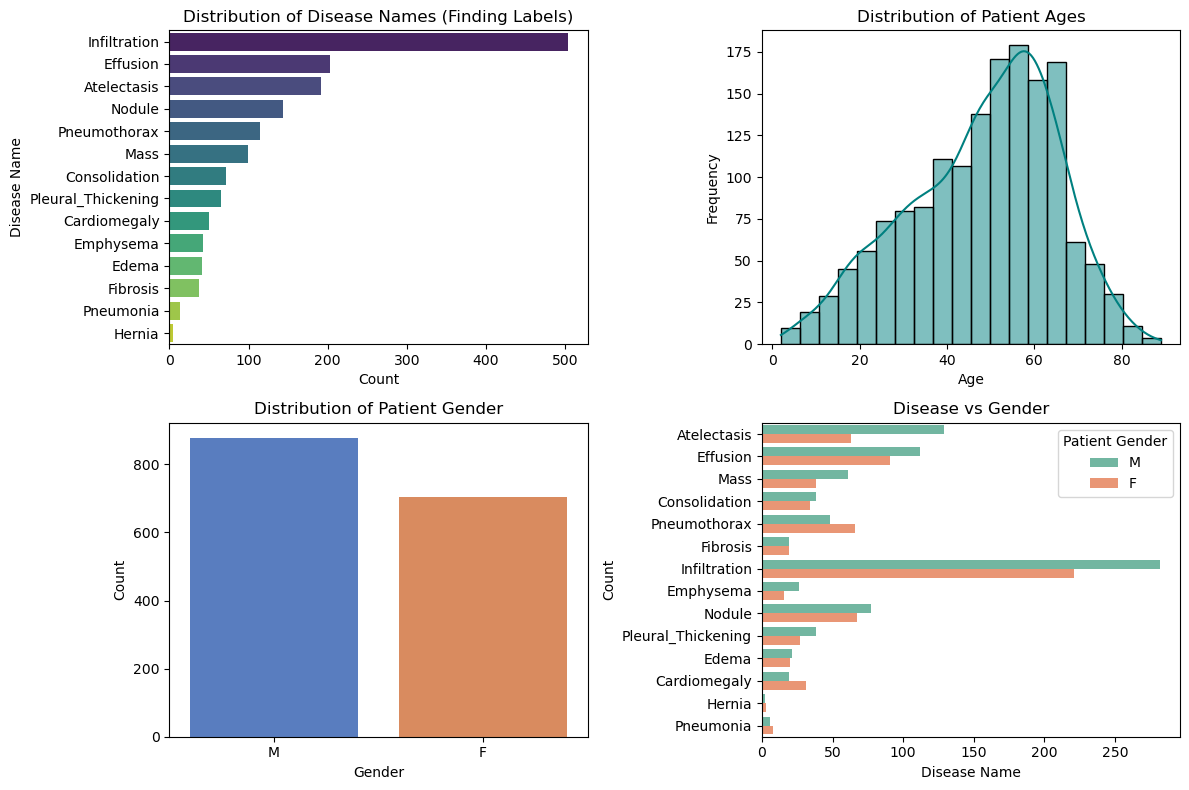

In [7]:

# Assuming your dataframe is called df

# Set the plot size for all plots
plt.figure(figsize=(12, 8))

# 1. Plot Distribution of Diseases (Finding Labels)
plt.subplot(2, 2, 1)  # Set subplot for positioning
sns.countplot(y='Finding Labels', data=df, order=df['Finding Labels'].value_counts().index, palette='viridis')
plt.title('Distribution of Disease Names (Finding Labels)')
plt.xlabel('Count')
plt.ylabel('Disease Name')

# 2. Plot Distribution of Patient Ages
plt.subplot(2, 2, 2)
sns.histplot(df['Patient Age'], bins=20, kde=True, color='teal')
plt.title('Distribution of Patient Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 3. Plot Distribution of Patient Gender
plt.subplot(2, 2, 3)
sns.countplot(x='Patient Gender', data=df, palette='muted')
plt.title('Distribution of Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# 4. Disease vs. Gender Count Plot
plt.subplot(2, 2, 4)
sns.countplot(y='Finding Labels', hue='Patient Gender', data=df, palette='Set2')
plt.title('Disease vs Gender')
plt.xlabel('Disease Name')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
def get_sample_by_finding_labels(df, sample_size):
    """
    Returns a sample of the DataFrame grouped by 'Finding Labels', 
    with 'sample_size' rows sampled from each disease group.

    Parameters:
    df (DataFrame): The input DataFrame.
    sample_size (int): The number of rows to sample from each 'Finding Labels' group.

    Returns:
    DataFrame: A DataFrame containing the sampled rows for each 'Finding Labels'.
    """
    # Group by 'Finding Labels' and apply sampling
    sampled_df = df.groupby('Finding Labels').apply(lambda x: x.sample(n=sample_size, random_state=42) if len(x) >= sample_size else x)
    
    # Reset index to avoid multi-indexing
    sampled_df = sampled_df.reset_index(drop=True)
    
    return sampled_df

In [9]:
sampled_df = get_sample_by_finding_labels(df, sample_size=X)

In [10]:
ollama.list()

ListResponse(models=[Model(model='mistral:latest', modified_at=datetime.datetime(2024, 12, 13, 10, 45, 44, 569754, tzinfo=TzInfo(+05:30)), digest='f974a74358d62a017b37c6f424fcdf2744ca02926c4f952513ddf474b2fa5091', size=4113301824, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama'], parameter_size='7.2B', quantization_level='Q4_0')), Model(model='llava:13b', modified_at=datetime.datetime(2024, 12, 13, 10, 14, 10, 253551, tzinfo=TzInfo(+05:30)), digest='0d0eb4d7f485d7d0a21fd9b0c1d5b04da481d2150a097e81b64acb59758fdef6', size=8011256494, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama', 'clip'], parameter_size='13B', quantization_level='Q4_0')), Model(model='llama3.2-vision:latest', modified_at=datetime.datetime(2024, 12, 12, 23, 58, 53, 867994, tzinfo=TzInfo(+05:30)), digest='085a1fdae525a3804ac95416b38498099c241defd0f1efc71dcca7f63190ba3d', size=7901829417, details=ModelDetails(parent_model='', format='gguf', fami

In [11]:
# Function to get Patient Problem from the text LLM 
def get_patient_problem(patient_disease_name):
    generate_patient_problem_prompt = prompt = prompt = f"""
    I am a patient suffering from {patient_disease_name}.
    Generate randomly a mix of direct or indirect symptoms that I am experience from {patient_disease_name}. 
    Remember The output should be First person prespective, where in I am telling this to a radiologist.
    Do not mention the disease name {patient_disease_name}.
    """
    generate_patient_problem_response = ollama.generate(
                model='llama3.2:latest',
                prompt=generate_patient_problem_prompt
            )    
    # Send request to Ollama visual model (replace with correct endpoint/API)
    patient_problem_response = generate_patient_problem_response['response']
    return patient_problem_response


In [12]:
def get_radiologist_response(patient_disease_name, patient_problem_response, xray_image_path):
    # Step 1: Process the X-ray image using the Llava (Ollama) visual model.
    generate_xray_prompt = f"""
    I am a expert radiologist reviewing an X-ray image for a patient with disease {patient_disease_name}.
    The patient reports the following symptoms:
    {patient_problem_response}
    
    Please analyze the X-ray image and provide a detailed analysis.
    Focus on identifying any anomalies or signs of the disease. The response should have 
    Clear observations of the disease's impact on the X-ray,
    Any potential complications that might be visible in the image.
    A diagnosis based on visual evidence and the provided symptoms.
    Don't include any AI Messages / Warnings.
    """
    
    # Assuming the Ollama API takes the path for an image as input, and disease name for context.
    generate_xray_response = ollama.generate(
        model='llava:7b', 
        images=[xray_image_path],
        prompt=generate_xray_prompt
    )
    
    # Step 2: Combine the visual insights from the X-ray analysis with the patient’s reported symptoms.
    xray_analysis = generate_xray_response['response']


    # Now, we need to return a final radiologist response that incorporates both the text and visual model insights.
    generate_radiologist_prompt = f"""
    I am a expert radiologist.
    Based on the symptoms reported by the patient:
    {patient_problem_response}
    
    After reviewing the X-ray image and considering the disease context:
    {xray_analysis}
    
    The Findings , impression and  recommendations are as follows:
    Don't include any AI Messages / Warnings.
    """
    generate_radiologist_response = ollama.generate(
        model='llama3.2:latest', 
        prompt=generate_radiologist_prompt
    )
    
    radiologist_response = generate_radiologist_response['response']
    
    return radiologist_response


In [13]:
#Test
#C:\Users\adity\Downloads\Sample_NIH Chest X-rays\sample\images\00007352_000.png
#patient_problem=get_patient_problem('Hernia')
#print(get_radiologist_response('Hernia',patient_problem,'C:\\Users\\adity\\Downloads\\Sample_NIH Chest X-rays\\sample\\images\\00007352_000.png'))

In [14]:
def save_patient_data_as_json(df, json_file_path):
    """
    Iterates through the sampled_df and generates a structured JSON format with 'instruction', 'input', and 'output'.
    
    Parameters:
    sampled_df (DataFrame): A DataFrame containing the sampled patient data.
    json_file_path (str): The path where the JSON file will be saved.
    """
    # Initialize an empty list to collect the records
    records = []
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)
    with open(json_file_path, 'w') as json_file:
        json_file.write('[')
        first_iteration = True
        
        for index, row in sampled_df.iterrows():
            # For each row, extract necessary details
            finding_label = row['Finding Labels']
            patient_id = row['Patient ID']
            patient_age = row['Patient Age']
            patient_gender = row['Patient Gender']
            view_position = row['View Position']
            xray_image_path = row['Image_Full_Path']  # Assuming image path is generated dynamically
            print(xray_image_path)
            # 1. Generate the 'patient_problem_response' (this part can be customized based on your method)
            patient_problem_response = get_patient_problem(finding_label)

            # 2. Generate the 'radiologist_response' (this can be derived from your visual model or other logic)
            radiologist_response = get_radiologist_response(finding_label,patient_problem_response,xray_image_path)

            # 3. Create the data structure for each record
            record = {
                "instruction": patient_problem_response.strip(),
                "input": "",
                "output": radiologist_response.strip()
            }

#             # Append the record to the list
#             records.append(record)
            if not first_iteration:
                json_file.write(',\n')  # Add a comma before every record after the first
            json.dump(record, json_file, indent=4)
            first_iteration = False  # Set flag to False after the first iteration

    # Write the closing bracket to complete the JSON array
    #json_file.write('\n]')
            

    
    
#     # Save the collected records as a JSON file
#     with open(json_file_path, 'w') as json_file:
#         json.dump(records, json_file, indent=4)

    print(f"Data saved to {json_file_path}")


In [15]:
sampled_df.head(2)

json_file_path = 'C:/DataSet/disease/patient_radiologist_data.json' 
save_patient_data_as_json(sampled_df, json_file_path)


C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00005365_002.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00018936_003.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00005066_065.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00017417_000.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00002425_000.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00025958_001.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00015799_007.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00011985_008.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00001816_001.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00001301_047.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00017266_003.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00009845_026.png
C:/Users/adity/Downloads/Sample_NIH Ches

In [17]:
#Convert the Data in Alpaca Format

# Load data from the existing JSON file (patient_radiologist_data.json)
input_filename = 'C:/DataSet/disease/patient_radiologist_data.json' 
output_filename = 'C:/DataSet/disease/alpaca_patient_radiologist_data.json' 
with open(input_filename, "r") as infile:
    data = json.load(infile)

# List to store the converted data in Alpaca format
alpaca_data = []

# Iterate through each entry in the input data and convert it
for entry in data:
    alpaca_entry = {
        "prompt": entry["instruction"],
        "completion": entry["output"]
    }
    alpaca_data.append(alpaca_entry)

# Save the converted data as Alpaca formatted JSON
with open(output_filename, "w") as outfile:
    json.dump(alpaca_data, outfile, indent=4)

print(f"Alpaca format data saved to {output_filename}")


Alpaca format data saved to C:/DataSet/disease/alpaca_patient_radiologist_data.json


In [23]:
mask = df.isin(sampled_df.to_dict(orient='list')).all(axis=1)

# Filter out rows that are present in sampled_df
remaining_rows = df[~mask]

sampled_df2 = get_sample_by_finding_labels(remaining_rows, sample_size=X)
sampled_df2.head(2)
save_patient_data_as_json(sampled_df2, json_file_path)

C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00005365_002.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00018936_003.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00005066_065.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00017417_000.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00002425_000.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00025958_001.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00015799_007.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00011985_008.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00001816_001.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00001301_047.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00017266_003.png
C:/Users/adity/Downloads/Sample_NIH Chest X-rays/sample/images/00009845_026.png
C:/Users/adity/Downloads/Sample_NIH Ches